In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


In [2]:
# load local model file and initialize model class
from model import ModelClass
model = ModelClass() # set a few number of periods.


par = model.par
sol = model.sol
sim = model.sim

In [4]:
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve()

CPU times: total: 2min 47s
Wall time: 27 s


In [5]:
# %time model.simulate_prep()
%time model.simulate()

CPU times: total: 906 ms
Wall time: 818 ms


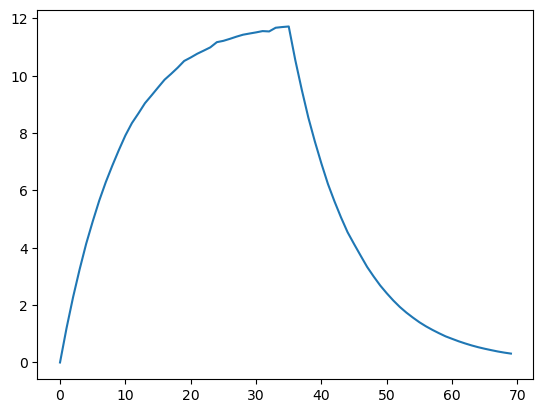

In [6]:
plt.plot(np.arange(par.T),np.mean(model.sim.k[:], axis=0))


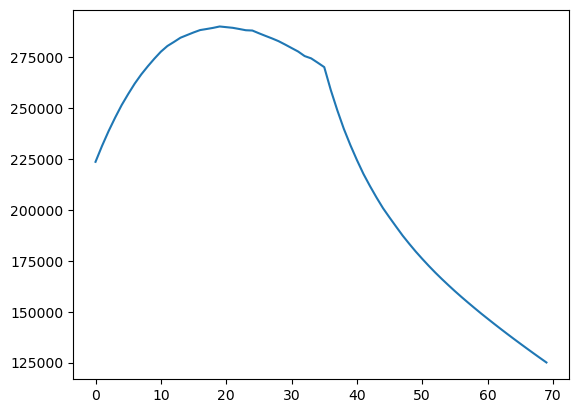

In [7]:
plt.plot(np.arange(par.T),np.mean(model.sim.w[:], axis=0))


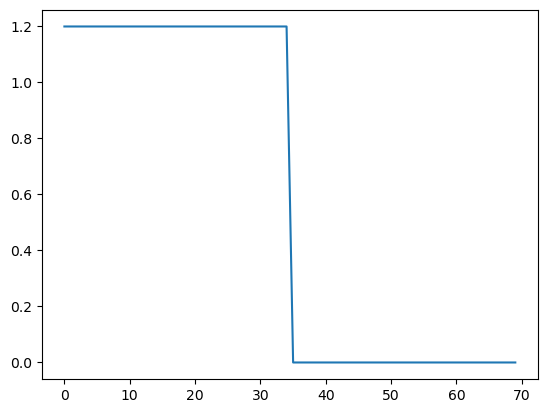

In [8]:
plt.plot(np.arange(par.T),np.mean(model.sim.h[:], axis=0))


In [9]:
model.sim.a[:]

array([[135000.        , 135000.00000015, 139106.51651829, ...,
         16372.62440574,  15873.08512187,  15264.78542479],
       [135000.        , 135000.00000015, 138368.98382507, ...,
         16374.81061188,  15874.14239056,  15264.98785941],
       [135000.        , 135000.00000015, 139106.51651829, ...,
         16374.90178163,  15874.18648105,  15264.9963014 ],
       ...,
       [135000.        , 135000.00000015, 138368.98382507, ...,
         16384.60229505,  15878.87773541,  15265.89453318],
       [135000.        , 135000.00000015, 138050.36272201, ...,
         16373.82407996,  15873.66529497,  15264.8965102 ],
       [135000.        , 135000.00000015, 139106.51651829, ...,
         16385.5709418 ,  15879.34618158,  15265.9842263 ]])

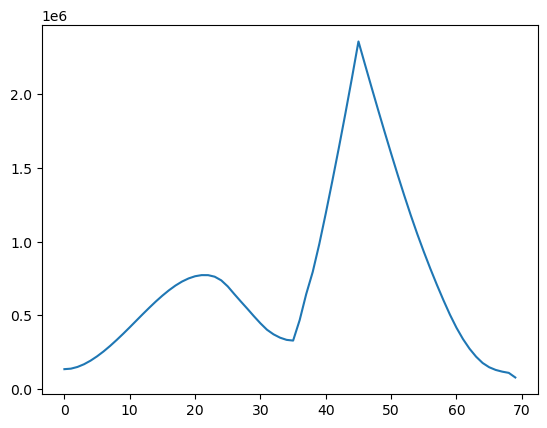

In [9]:
plt.plot(np.arange(par.T),np.mean(model.sim.a[:], axis=0))


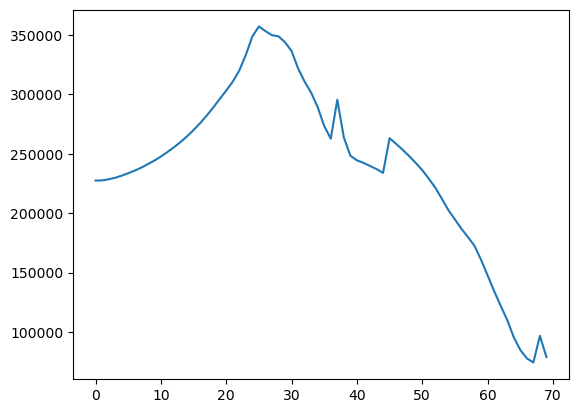

In [10]:
plt.plot(np.arange(par.T),np.mean(model.sim.c[:], axis=0))


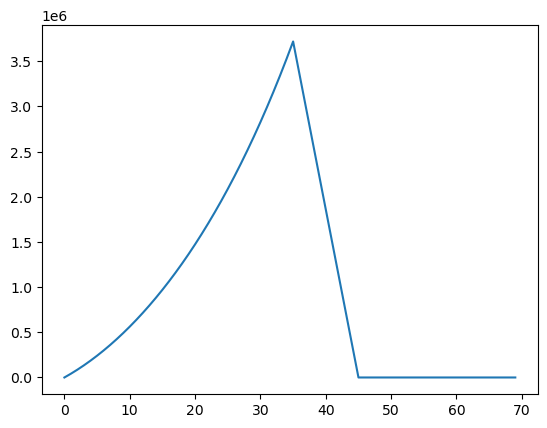

In [11]:
plt.plot(np.arange(par.T),np.mean(model.sim.s[:], axis=0))


In [ ]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 1, 1, i])


In [ ]:
sol.V

In [ ]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.V[:, 1, 1, i])


In [ ]:
sol.V[:, 4, 4, :]

In [ ]:
for i in range(sol.V.shape[3]):
    plt.plot(np.arange(par.T),sol.c[:, 4, 4, i])

In [ ]:
sol.V[:-1, 4, 4, 4]-sol.V[1:, 4, 4, 4]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Choose a fixed k index (e.g., middle of the k_grid)
k_idx = 2
k_fixed = par.k_grid[k_idx]  

# Extract the meshgrid for plotting
a_mesh, s_mesh = np.meshgrid(par.a_grid, par.s_grid, indexing='ij')

# Extract solutions at time t and fixed k
t = 30
c_plot = sol.c[t, :, :, k_idx]  # Fix k_idx
h_plot = sol.h[t, :, :, k_idx]
V_plot = sol.V[t, :, :, k_idx]

# Plot consumption
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, c_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Consumption, $c_{T}^{\star}$', title=f'Consumption at $k_T = {k_fixed:.2f}$')

# Plot labor supply
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, h_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Hours, $h_{T}^{\star}$', title=f'Labor Supply at $k_T = {k_fixed:.2f}$')

# Plot value function
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(a_mesh, s_mesh, V_plot, rstride=1, cstride=1, cmap='viridis', edgecolor='none', alpha=0.75)
ax.set(xlabel='Liquid assets, $a_{T}$', ylabel='Illiquid assets, $s_T$', zlabel='Value, $V_{T}$', title=f'Value Function at $k_T = {k_fixed:.2f}$')

plt.show()
